Prior work for default patience:

* `torch.optim.ReduceLROnPlateau` default to `patience=10` epochs
    * https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau
* `keras.ReduceOnPlateau` defaults to `patience=10` epochs.
    * https://github.com/tensorflow/tensorflow/blob/4dcfddc5d12018a5a0fdca652b9221ed95e9eb23/tensorflow/python/keras/callbacks.py#L891
* MXNet defaults to `patience=10` epochs in their ReduceLROnPlateau
    * https://github.com/awslabs/keras-apache-mxnet/blob/01d59d3f91ffb13d73cadc11db94a30e4b05c2f8/keras/callbacks.py#L991
* "Random Search for Hyper-Parameter Optimization" says "We permitted a minimum of 100 and a maximum of 1000 iterations over the training data, stopping if ever, at iteration $t$ , [if] the best validation performance was observed before iteration $t / 2$."
    *  by Bengio et. al. http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf (mentioned in the sklearn docs at http://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization)
    
An approach like the last seems ideal and similar to the doubling trick. But they have a minimum number of iterations; that's what we're trying to choose.

I think a static patience parameter is best.

I am inclined to have this in terms of epochs; I think there's some paper that says "run for X epochs" for convergence.

It looks like we should default to 10; that's what everyone else is doing (including Facebook, Amazon and Google).

## Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import distributed
from distributed import Client
client = Client()
client

Client Scheduler: tcp://dask-scheduler:8786 Dashboard: http://dask-scheduler:8787/status,Cluster Workers: 16 Cores: 32 Memory: 96.00 GB


In [3]:
client.ncores()

{'tcp://10.52.101.3:32807': 2,
 'tcp://10.52.102.3:42949': 2,
 'tcp://10.52.103.4:39683': 2,
 'tcp://10.52.104.3:35883': 2,
 'tcp://10.52.105.3:44301': 2,
 'tcp://10.52.106.3:44269': 2,
 'tcp://10.52.107.3:45867': 2,
 'tcp://10.52.108.3:34393': 2,
 'tcp://10.52.109.3:35189': 2,
 'tcp://10.52.110.3:39023': 2,
 'tcp://10.52.111.4:36131': 2,
 'tcp://10.52.112.3:41667': 2,
 'tcp://10.52.114.3:43839': 2,
 'tcp://10.52.115.3:46805': 2,
 'tcp://10.52.116.3:36847': 2,
 'tcp://10.52.117.3:34885': 2}

In [4]:
import subprocess
def debug_loop():
    subprocess.call("pip install git+https://github.com/stsievert/dask-ml@hyperband-scale".split(" "))
    import dask_ml
    return dask_ml.__version__

In [5]:
%time debug_loop()

CPU times: user 136 ms, sys: 21.6 ms, total: 157 ms
Wall time: 3.26 s


'0.4.2.dev395+g7b1cf92'

In [6]:
from dask_ml.model_selection._successive_halving import _SHA
#_SHA.fit??

In [7]:
%time client.run(debug_loop)

CPU times: user 11.4 ms, sys: 2.42 ms, total: 13.9 ms
Wall time: 3.67 s


{'tcp://10.52.101.3:32807': '0.4.2.dev395+g7b1cf92',
 'tcp://10.52.102.3:42949': '0.4.2.dev395+g7b1cf92',
 'tcp://10.52.103.4:39683': '0.4.2.dev395+g7b1cf92',
 'tcp://10.52.104.3:35883': '0.4.2.dev395+g7b1cf92',
 'tcp://10.52.105.3:44301': '0.4.2.dev395+g7b1cf92',
 'tcp://10.52.106.3:44269': '0.4.2.dev395+g7b1cf92',
 'tcp://10.52.107.3:45867': '0.4.2.dev395+g7b1cf92',
 'tcp://10.52.108.3:34393': '0.4.2.dev395+g7b1cf92',
 'tcp://10.52.109.3:35189': '0.4.2.dev395+g7b1cf92',
 'tcp://10.52.110.3:39023': '0.4.2.dev395+g7b1cf92',
 'tcp://10.52.111.4:36131': '0.4.2.dev395+g7b1cf92',
 'tcp://10.52.112.3:41667': '0.4.2.dev395+g7b1cf92',
 'tcp://10.52.114.3:43839': '0.4.2.dev395+g7b1cf92',
 'tcp://10.52.115.3:46805': '0.4.2.dev395+g7b1cf92',
 'tcp://10.52.116.3:36847': '0.4.2.dev395+g7b1cf92',
 'tcp://10.52.117.3:34885': '0.4.2.dev395+g7b1cf92'}

In [8]:
%time client.restart()

CPU times: user 3.5 ms, sys: 1.44 ms, total: 4.95 ms
Wall time: 206 ms


Client Scheduler: tcp://dask-scheduler:8786 Dashboard: http://dask-scheduler:8787/status,Cluster Workers: 16 Cores: 32 Memory: 96.00 GB


In [9]:
%time client.upload_file('autoencoder.py')

CPU times: user 4.41 ms, sys: 3.43 ms, total: 7.85 ms
Wall time: 985 ms


In [10]:
from dask_ml.model_selection._successive_halving import stop_on_plateau
from dask_ml.model_selection import HyperbandCV
import dask_ml
dask_ml.__version__

'0.4.2.dev395+g7b1cf92'

## Data
See below for an image.

In [11]:
import noisy_mnist
_X, _y = noisy_mnist.dataset()#n=10 * 1024)

Using TensorFlow backend.


In [12]:
import dask.array as da
n, d = _X.shape
X = da.from_array(_X, chunks=(n // 2, d))
y = da.from_array(_y, chunks=n // 2)
X, y

(dask.array<array, shape=(70000, 784), dtype=float32, chunksize=(35000, 784)>,
 dask.array<array, shape=(70000, 784), dtype=float32, chunksize=(35000, 784)>)

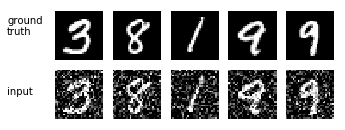

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
cols = 5
w = 1.0
fig, axs = plt.subplots(figsize=(cols*w, 2*w), ncols=cols, nrows=2)
for col, (upper, lower) in enumerate(zip(axs[0], axs[1])):
    if col == 0:
        upper.text(-28, 14, 'ground\ntruth')
        lower.text(-28, 14, 'input')
    i = np.random.choice(len(X))
    noisy = X[i].reshape(28, 28)
    clean = y[i].reshape(28, 28)
    kwargs = {'cbar': False, 'xticklabels': False, 'yticklabels': False, 'cmap': 'gray'}
    sns.heatmap(noisy, ax=lower, **kwargs)
    sns.heatmap(clean, ax=upper, **kwargs)
plt.show()

## Model

I use a deep learning library (PyTorch) for this model, at least through the scikit-learn interface for PyTorch, [skorch].

[skorch]:https://github.com/dnouri/skorch

In [14]:
from autoencoder import Autoencoder, NegLossScore
import torch

model = NegLossScore(module=Autoencoder,
                     criterion=torch.nn.BCELoss,
                     warm_start=True,
                     train_split=None,
                     max_epochs=1,
                     callbacks=[])

I don't show it here; I'd rather concentrate on tuning hyperparameters. But briefly, it's a simple fully connected 3 hidden layer autoencoder with a latent dimension of 49.

## Parameters

The parameters I am interested in tuning are

* model
    * initialization
    * activation function
    * weight decay (which is similar to $\ell_2$ regularization)
* optimizer
    * which optimizer to use (e.g., Adam, SGD)
    * batch size used to approximate gradient
    * learning rate (but not for Adam)
    * momentum for SGD
    
After looking at the results, I think I was too exploratory in my tuning of step size. I should have experimented with it more to determine a reasonable range.

In [15]:
import numpy as np

params = {
    'module__init': ['xavier_uniform_',
                     'xavier_normal_',
                     'kaiming_uniform_',
                     'kaiming_normal_',
                    ],
    'module__activation': ['ReLU', 'LeakyReLU', 'ELU', 'PReLU'],
    'optimizer': ['SGD'] * 5 + ['Adam'] * 2,
    'batch_size': [32, 64, 128, 256, 512],
    'optimizer__lr': np.logspace(1, -1.5, num=1000),
    'optimizer__weight_decay': [0]*200 + np.logspace(-7, -3, num=1000).tolist(),
    'optimizer__nesterov': [True],
    'optimizer__momentum': np.linspace(0, 1, num=1000),
    'train_split': [None],
}

In [16]:
from sklearn.model_selection import ParameterSampler
import torch

def trim_params(**kwargs):
    if kwargs['optimizer'] != 'Adam':
        kwargs.pop('optimizer__amsgrad', None)
    if kwargs['optimizer'] == 'Adam':
        kwargs.pop('optimizer__lr', None)
    if kwargs['optimizer'] != 'SGD':
        kwargs.pop('optimizer__nesterov', None)
        kwargs.pop('optimizer__momentum', None)
    kwargs['optimizer'] = getattr(torch.optim, kwargs['optimizer'])
    return kwargs

In [17]:
# # for debugging; ignore this cell
# from sklearn.linear_model import SGDClassifier
# from sklearn.datasets import make_classification
# from sklearn.model_selection import ParameterSampler
# import dask.array as da
# import numpy as np
# model = SGDClassifier()
# params = {'alpha': np.logspace(-7, 0, num=int(1e6))}

# n, d = int(10e3), 700
# _X = np.random.rand(n, d)
# _beta = np.random.rand(d)
# _y = np.sign(_X @ _beta + d * 0.1 * np.random.randn(n))
# X = da.from_array(_X, chunks=(n // 10, d))
# y = da.from_array(_y, chunks=n // 10)
# X, y

## Hyperparameter optimization

In [18]:
from dask_ml.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from dask_ml.model_selection import HyperbandCV

def test_hyperband(model, params, X, y, max_iter=27, patience=np.inf, tol=1e-4):
    fit_params = {}
    if isinstance(model, SGDClassifier):
        fit_params = {'classes': da.unique(y).compute()}
        param_list = list(ParameterSampler(params, max_iter * 100))
    else:
        param_list = [trim_params(**param)
                      for param in ParameterSampler(params, max_iter * 100)]
        
    search = HyperbandCV(model, param_list, max_iter, patience=patience)
    search.fit(X, y, **fit_params)
    
    meta = {'max_iter': max_iter, 'patience': patience, 'tol': tol, "alg": "hyperband"}
    [h.update(meta) for h in search.history_]
    return search, search.history_

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
max_iter = 243

In [22]:
all_history = {}

In [ ]:
searches = []

# [inf, 5, 10] epochs respectively
# P = [max_iter, 20, 10]
P = [20, 40, max_iter]
# 10, 20, 40 and 121 epochs respectively
for p in P:
    all_history[f"hyperband-p{p}"] = []
for _ in range(3):
    for p in P:
        search, hist = test_hyperband(model, params, X_train, y_train, max_iter=max_iter, patience=p)
        if p == max_iter:
            searches += [search]
        all_history[f"hyperband-p{p}"] += [hist]
        print(p, _, search.best_score_)

20 0 -0.09480269998311996
40 0 -0.09297627210617065
243 0 -0.09296257048845291
20 1 -0.09345395863056183
40 1 -0.09191805869340897
243 1 -0.09264714270830154


## Visualizing output of best estimator

In [ ]:
noisy_test = X_test.compute()

In [ ]:
search = searches[0]
clean_hat = search.best_estimator_.predict(noisy_test)
clean_hat.shape

In [ ]:
import matplotlib.pyplot as plt
cols = 5
w = 1.0
fig, axs = plt.subplots(figsize=(cols*w, 3*w), ncols=cols, nrows=3)
for col, (upper, middle, lower) in enumerate(zip(axs[0], axs[1], axs[2])):
    if col == 0:
        upper.text(-28, 14, 'ground\ntruth')
        middle.text(-28, 14, 'input')
        lower.text(-28, 14, 'output')
    i = np.random.choice(len(X_test))
    noisy = X_test[i].reshape(28, 28)
    clean = y_test[i].reshape(28, 28)
    clean_hat_i = clean_hat[i].reshape(28, 28)
    kwargs = {'cbar': False, 'xticklabels': False, 'yticklabels': False, 'cmap': 'gray'}
    sns.heatmap(noisy, ax=middle, **kwargs)
    sns.heatmap(clean, ax=upper, **kwargs)
    sns.heatmap(clean_hat_i, ax=lower, **kwargs)
plt.show()

### Setting parameters for Hyperband
Need to know two things:

1. how many "epochs" or "passes through data" to train model
2. how many configs to evaluate
    * this is some measure of how complex the search space is
    
This determines

* The `max_iter` argument for `HyperbandCV`
* the chunks size for the array to pass in


## Comparison with early stopping

In [ ]:
from dask_ml.model_selection._successive_halving import _HistoryRecorder, stop_on_plateau
from dask_ml.model_selection._incremental import fit
from dask_ml.model_selection import train_test_split
from sklearn.model_selection import ParameterSampler
import random

def test_rand(model, params, X, y, max_iter, num_models, num_calls, patience=10, tol=1e-4):
    rand_search = _HistoryRecorder(stop_on_plateau, patience=patience, tol=tol, max_iter=num_calls)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
    
    if isinstance(model, SGDClassifier):
        rand_params = list(ParameterSampler(params, int(num_models)))
        fit_params = {'classes': da.unique(y).compute()}
    else:
        rand_params = [trim_params(**param)
                      for param in ParameterSampler(params, int(num_models))]
        fit_params = {}

    _ = fit(
        model,
        rand_params,
        X_train,
        y_train,
        X_test,
        y_test,
        additional_partial_fit_calls=rand_search.fit,
        fit_params=fit_params,
        random_state=42
    )
    meta = {'max_iter': max_iter, 'patience': patience, 'tol': tol, "alg": "stop_on_plateau"}
    [h.update(meta) for h in rand_search.history]
    return rand_search.history

In [ ]:
total_calls = search.metadata()['partial_fit_calls']
num_calls = max_iter
num_models = max(sum(client.ncores().values()), total_calls // num_calls)
num_calls, num_models, search.metadata()['partial_fit_calls']

In [ ]:
#P = [max_iter, 10, 20]
P = [20, 40, 80, max_iter]
P = [20, 40, 80, 120, max_iter]
for p in P:
    all_history[f"random-p{p}"] = []
for p in P:
    for _ in range(3):
        all_history[f"random-p{p}"] += [test_rand(model, params, X, y, max_iter, num_models, num_calls, patience=p)]
        print(p, _)

## Performance
`HyperbandCV` will find close to the best possible parameters with the given computational budget.*

<sup>* "will" := with high probability,
"close" := within log factors,
"best possible" in expected value.</sup>


In [24]:
'hi'

'hi'

In [25]:
from pprint import pprint
import toolz

def shape_history(hist, **kwargs):
    history = sorted(hist, key=lambda item: item['wall_time'])
    
    out = []
    scores = {}
    calls = {}
    train_time = {}
    
    start = min(h['wall_time'] for h in history)
    for h in history:
        scores[h['model_id']] = h['score']
        calls[h['model_id']] = h['partial_fit_calls']
        train_time[h['model_id']] = h['partial_fit_time'] + h['score_time']
        p = h["patience"]
        out += [{'wall_time': h['wall_time'] - start,
                 'best_score': max(scores.values()),
                 'cumulative_partial_fit_calls': sum(calls.values()),
                 'alg': h['alg'],
                 'adaptive': not "hyperband" in h["alg"],
                 'train_time': sum(train_time.values()),
                 'model_id': h["model_id"],
                 'patience': p if not np.isinf(p) else -1,
                 'patience_': "p=" + str(p) if not np.isinf(p) else "p=inf",
                 'tol': h["tol"],
                 'base_alg': "hyperband" if "hyperband" in h["alg"] else "stop_on_plateau",
                 **kwargs
                }]
    return out


In [26]:
shaped_history = [shape_history(h, repeat=repeat, alg=alg)
                  for alg, hist in all_history.items()
                  for repeat, h in enumerate(hist)]
alg_shaped_histories = {alg: [shape_history(h, repeat=repeat, alg=alg)
                              for repeat, h in enumerate(hist)]
                        for alg, hist in all_history.items()}
history = sum(shaped_history, [])


In [27]:
import pandas as pd
df = pd.DataFrame(history)
df.to_csv('2018-09-10-history.csv')
print(df.alg.unique())
print(df.patience.unique())
df.head()

['hyperband-p20' 'hyperband-p40' 'hyperband-p243']
[ 20  40 243]


,adaptive,alg,base_alg,best_score,cumulative_partial_fit_calls,model_id,patience,patience_,repeat,tol,train_time,wall_time
0,False,hyperband-p20,hyperband,-0.542950,1,bracket=2-0,20,p=20,0,0.0,8.795053,0.000000e+00
1,False,hyperband-p20,hyperband,-0.542950,2,bracket=2-1,20,p=20,0,0.0,12.844531,9.536743e-07
2,False,hyperband-p20,hyperband,-0.253263,3,bracket=2-2,20,p=20,0,0.0,17.382286,1.430511e-06
3,False,hyperband-p20,hyperband,-0.211405,4,bracket=2-3,20,p=20,0,0.0,23.095830,1.907349e-06
4,False,hyperband-p20,hyperband,-0.211405,5,bracket=2-4,20,p=20,0,0.0,28.456335,2.145767e-06


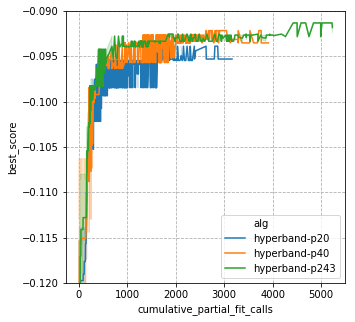

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

w = 5
fig, ax = plt.subplots(figsize=(w, w))

# adaptiveness = sorted([a for a in df.alg.unique() if a not in ['hyperband', 'stop_on_plateau']])
# adaptiveness = ['stop_on_plateau', 'hyperband']

x = "cumulative_partial_fit_calls"
show = df.copy()

sns.lineplot(
    x=x,
    y='best_score',
    hue="alg",
    data=show,
    ax=ax,
    estimator='mean',
)
ax.grid(linestyle='--')
# ax.set_ylim(-0.13, -0.09)
# ax.set_ylim(0.85, 0.875)
# plt.savefig('./successive-halving-comparison.png', dpi=300, bbox_inches='tight')
ax.set_ylim(-0.12, -0.09)
plt.show()

In [37]:
def shape_histories(histories, **kwargs):
    histories = sum(histories, [])
    _df = pd.DataFrame(histories)
    _df = _df.sort_values(by="wall_time")
    
    data = []
    most_recent_scores = {}
    most_recent_times = {}
    for _, datum in _df.iterrows():
        most_recent_scores[datum["repeat"]] = datum["best_score"]
            
        most_recent_times[datum["repeat"]] = datum["wall_time"]
        scores = np.array(list(most_recent_scores.values()))
        
        data += [{"best_score_mean": scores.mean(),
                  "best_score_std": np.std(scores),
                  "best_score_max": scores.max(),
                  "best_score_median": np.median(scores),
                  "best_score_min": scores.min(),
                  "wall_time (s)": datum["wall_time"],
                  "wall_time (min)": datum["wall_time"] / 60,
                  "alg": datum["alg"],
                  "patience": datum["patience"],
                  "tol": datum["tol"],
                  **kwargs}]
    return data

In [38]:
histories = [shape_histories(alg_hist, alg=alg) for alg, alg_hist in alg_shaped_histories.items()]
time_df = pd.DataFrame(sum(histories, []))
time_df.to_csv('2018-09-10-shaped-history-more-freq-score.csv')
time_df.head()

,alg,best_score_max,best_score_mean,best_score_median,best_score_min,best_score_std,patience,tol,wall_time (min),wall_time (s)
0,hyperband-p20,-0.542950,-0.542950,-0.542950,-0.54295,0.000000,20,0.0,0.000000e+00,0.000000e+00
1,hyperband-p20,-0.130327,-0.336639,-0.336639,-0.54295,0.206311,20,0.0,0.000000e+00,0.000000e+00
2,hyperband-p20,-0.130327,-0.433896,-0.542950,-0.62841,0.217472,20,0.0,0.000000e+00,0.000000e+00
3,hyperband-p20,-0.130327,-0.359529,-0.405311,-0.54295,0.171535,20,0.0,7.947286e-09,4.768372e-07
4,hyperband-p20,-0.130327,-0.359529,-0.405311,-0.54295,0.171535,20,0.0,1.192093e-08,7.152557e-07


Text(0,0.5,'Best score')

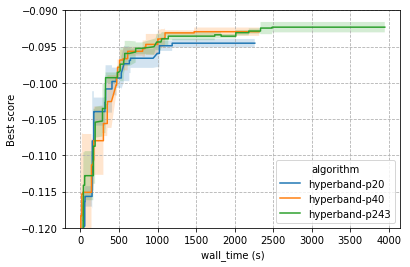

In [42]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

key = "wall_time (s)"
for alg in time_df.alg.unique():
    s = time_df[time_df.alg == alg]
    ax.plot(s[key].values, s["best_score_mean"].values, label=alg)
    ax.fill_between(
        s[key],
        s.best_score_mean - s.best_score_std,
        s.best_score_mean + s.best_score_std,
        alpha=0.2,
    )
ax.set_ylim(-0.12, -0.09)
ax.legend(loc="lower right", title="algorithm")
ax.set_xlabel(key)
ax.grid(linestyle='--')
ax.set_ylabel("Best score")

## Parameter visualization

In [43]:
hist = pd.DataFrame(search.cv_results_)
hist['param_optimizer_'] = hist['param_optimizer'].apply(lambda opt: str(opt).replace('<class', '').strip('>'))
hist['test_loss'] = -1 * hist['test_score']
hist = hist.sort_values(by='test_loss')
hist['rank'] = np.arange(len(hist)) + 1

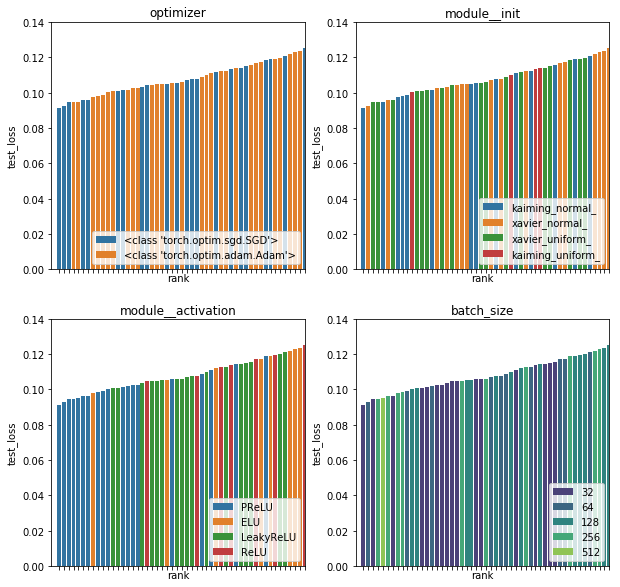

In [48]:
w = 5
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(2*w, 2*w))
axs = axs.flat[:]
hues = ['param_optimizer', 'param_module__init', 'param_module__activation', 'param_batch_size']
for ax, hue in zip(axs, hues):
    cmap = None
    if 'batch_size' in hue:
        cmap = 'viridis'
    sns.barplot(
        x='rank', 
        y='test_loss',
        hue=hue,
        data=hist,
        ax=ax,
        palette=cmap,
        dodge=False,
    )
    ax.set_xlim(-1.5, 50)
    ax.set_ylim(0, 0.14)
    ax.grid(linestyle='--', which='y')
    ax.legend(loc='lower right')
    ax.set_title(hue.replace('param_', ''))
    ax.tick_params(labelbottom=False)
plt.savefig('2018-09-10-global-params.png', dpi=300)
plt.show()

In [45]:
sgd_alg = [a for a in hist.param_optimizer_.unique() if 'sgd' in a.lower()][0]
sgd = hist[hist.param_optimizer_ == sgd_alg]

[" 'torch.optim.sgd.SGD'"]


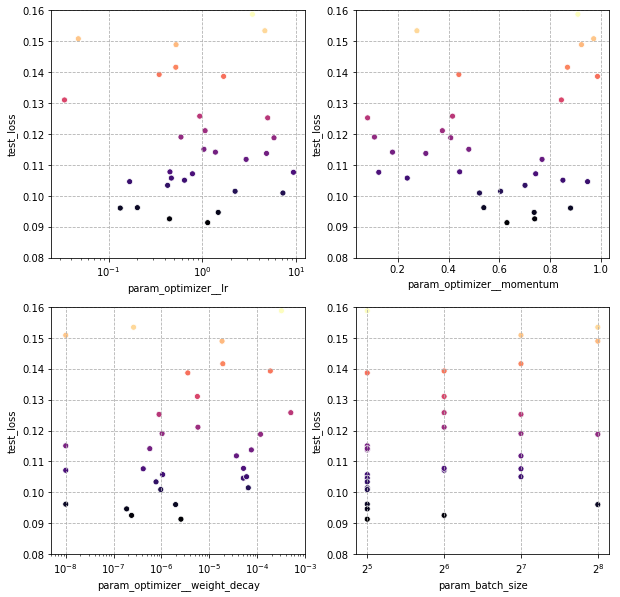

In [47]:
w = 5
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(2*w, 2*w))
axs = axs.flat[:]
variables = ['param_optimizer__lr', 'param_optimizer__momentum', 'param_optimizer__weight_decay', 'param_batch_size']
print(sgd.param_optimizer_.unique())
for ax, var in zip(axs, variables):
    show = sgd.copy()
    show = show.sort_values(by=var)
    if 'weight_decay' in var:
        show[var] += 1e-8
    show = show[show.test_loss < 0.16]
    sns.scatterplot(
        x=var,
        y='test_loss',
        data=show,
        hue='test_loss',
        palette='magma',
        legend=False,
        ax=ax,
    )
    if 'lr' in var:
        ax.set_xscale('log', basex=10)
    if 'batch_size' in var:
        ax.set_xscale('log', basex=2)
    if 'weight_decay' in var:
        ax.set_xlim(5e-9, 1e-3)
        ax.set_xscale('log', basex=10)
    
    ax.grid(linestyle='--')
    ax.set_ylim(0.08, 0.16)
plt.savefig('2018-09-10-sgd-params.png', dpi=300)
plt.show()